In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import copy

In [4]:
def set_seed(seed=0):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

### Create data

In [33]:
x = np.random.uniform(low=-2, high=6, size=100)
y = 1 + 0.5*x + 2*x**2 - 1/3*x**3 + np.random.standard_normal(x.shape)*0.3

### Plot data

Text(0.5, 0, 'x')

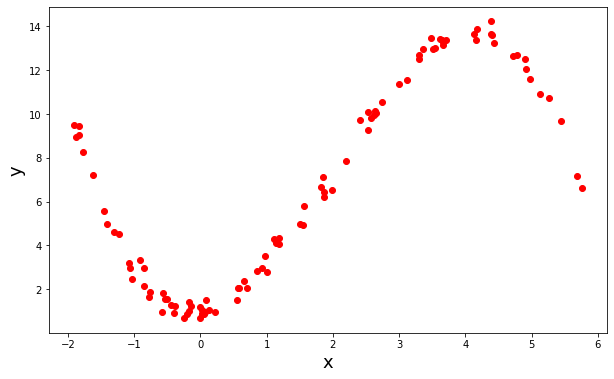

In [40]:
fig = plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', color='red')
plt.ylabel('y', fontsize=18)
plt.xlabel('x', fontsize=18)

In [63]:
x = x.reshape(-1, 1)

In [64]:
x.shape

(100, 1)

In [65]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=True).fit(x, y)

yhat = reg.predict(x)

In [66]:
yhat = reg.predict(np.arange(-2.1,6.1,0.001).reshape(-1, 1))

Text(0.5, 0, 'x')

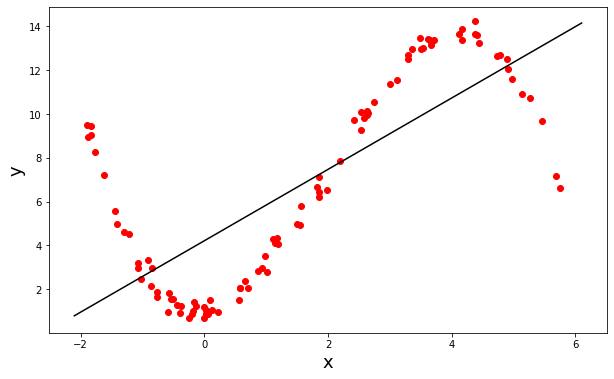

In [67]:
fig = plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', color='red')
plt.plot(np.arange(-2.1,6.1,0.001), yhat, '-', color='black')
plt.ylabel('y', fontsize=18)
plt.xlabel('x', fontsize=18)

In [69]:
z = np.hstack((x,x**2,x**3))
reg = LinearRegression(fit_intercept=True).fit(z, y)
yhat = reg.predict(z)

In [70]:
xnew = np.arange(-2.1,6.1,0.001).reshape(-1, 1)
z = np.hstack((xnew,xnew**2,xnew**3))
yhat = reg.predict(z)

Text(0.5, 0, 'x')

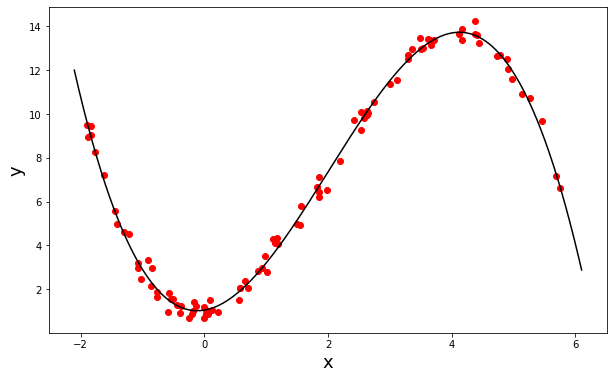

In [71]:
fig = plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', color='red')
plt.plot(np.arange(-2.1,6.1,0.001), yhat, '-', color='black')
plt.ylabel('y', fontsize=18)
plt.xlabel('x', fontsize=18)

### Step 1: Create a torch data loader

In [199]:
BATCH_SIZE = 16 # define batch size

In [200]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(x, dtype=torch.float),
    torch.tensor(y, dtype=torch.float).reshape(-1,1))

train_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE)

### Step 2: Build a Network

In [292]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.W1 = nn.Linear(1, 20) 
        self.W2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.W1(x)
        x = F.tanh(x)
        x = self.W2(x)
        return x

In [293]:
net = Net()
print(net)

Net(
  (W1): Linear(in_features=1, out_features=20, bias=True)
  (W2): Linear(in_features=20, out_features=1, bias=True)
)


### Step 3: Define a Loss Function

In [294]:
criterion = nn.MSELoss() # mean squared error (squared L2 norm)

### Step 4: Choose an Optimizer and Set Learning Rate

In [295]:
torch.manual_seed(1e5)

In [296]:
LEARNING_RATE = 0.01

In [297]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=0.0)

### Step 4: Train the Model

In [298]:
NUMBER_EPOCHS = 800

In [299]:
#net = Net()
loss_hist = []
for epoch in range(1, NUMBER_EPOCHS):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        outputs = net(inputs)        
        loss = criterion(outputs, targets) 
        loss.backward()        
        optimizer.step()
        optimizer.zero_grad()
    loss_hist.append(loss.item())
        
    if epoch % 50 == 0: print('Epoch: %s, Loss: %s', (epoch, loss.item()))

/home/ben/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: %s, Loss: %s (50, 0.5356564521789551)
Epoch: %s, Loss: %s (100, 0.37797510623931885)
Epoch: %s, Loss: %s (150, 0.06529146432876587)
Epoch: %s, Loss: %s (200, 0.02358739823102951)
Epoch: %s, Loss: %s (250, 0.019350919872522354)
Epoch: %s, Loss: %s (300, 0.018895907327532768)
Epoch: %s, Loss: %s (350, 0.019472507759928703)
Epoch: %s, Loss: %s (400, 0.019572068005800247)
Epoch: %s, Loss: %s (450, 0.019609782844781876)
Epoch: %s, Loss: %s (500, 0.019537974148988724)
Epoch: %s, Loss: %s (550, 0.019238699227571487)
Epoch: %s, Loss: %s (600, 0.01882072165608406)
Epoch: %s, Loss: %s (650, 0.018380064517259598)
Epoch: %s, Loss: %s (700, 0.017972707748413086)
Epoch: %s, Loss: %s (750, 0.017631979659199715)


Text(0.5, 0, 'epoch')

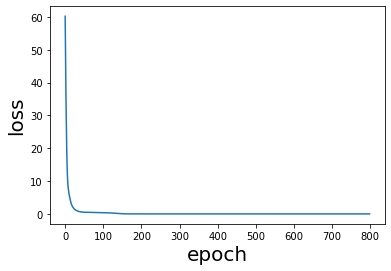

In [300]:
plt.plot(loss_hist)
plt.ylabel('loss', fontsize=20)
plt.xlabel('epoch', fontsize=20)

## Plotting regression line

In [301]:
xnew = np.arange(-2.1,6.1,0.001).reshape(-1, 1)

yhat = net(torch.from_numpy(xnew).float())

Text(0.5, 0, 'x')

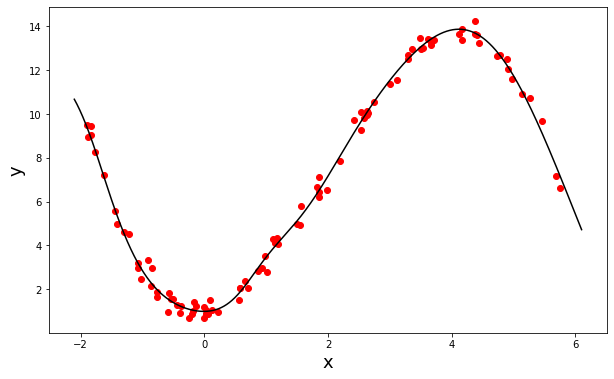

In [302]:
fig = plt.figure(figsize=(10,6))
plt.plot(x, y, 'o', color='red')
plt.plot(np.arange(-2.1,6.1,0.001), yhat.detach().numpy(), '-', color='black')
plt.ylabel('y', fontsize=18)
plt.xlabel('x', fontsize=18)

In [303]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression(fit_intercept=False).fit(x, y)

yhat = reg.predict(x)

In [304]:
reg.coef_

array([2.54249912])

In [325]:
def grad(x,y,w):
    return x.T.dot(x*w-y.reshape(-1,1))

In [326]:
w = 0
for i in range(20):
    w = w - 0.001 * grad(x,y,w)

In [327]:
w

array([[2.54249912]])